## Imports

In [2]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os
import json


/tmp/ipykernel_1155313/2315645241.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*           

## Set working directory

In [3]:
# ffs=input("Which force fields? (Options: JC, CHARMM27)")
# os.chdir("/home/bamo6610/Documents/GROMACS_files/MDAnalysis/SPW_ALL/%s"%ffs)

os.chdir("/home/bamo6610/Documents/GROMACS_files/MDAnalysis/SPW_ALL/JC")

## Loading data and creating atom group of ions

In [5]:
## 1 molal ##
u1m_o = mda.Universe('md_1m.gro', 'md_1m.xtc')
u1m_o.transfer_to_memory()
ions1m_o= u1m_o.select_atoms('resname SOD CLA')
densprof_1m_o="dens_o_1m.xvg"

u1m_r1 = mda.Universe('mdr1_1m.gro', 'mdr1_1m.xtc')
u1m_r1.transfer_to_memory()
ions1m_r1= u1m_r1.select_atoms('resname SOD CLA')
densprof_1m_r1="dens_r1_1m.xvg"

u1m_r2 = mda.Universe('mdr2_1m.gro', 'mdr2_1m.xtc')
u1m_r2.transfer_to_memory()
ions1m_r2= u1m_r2.select_atoms('resname SOD CLA')
densprof_1m_r2="dens_r2_1m.xvg"

u1m_r3 = mda.Universe('mdr3_1m.gro', 'mdr3_1m.xtc')
u1m_r3.transfer_to_memory()
ions1m_r3= u1m_r3.select_atoms('resname SOD CLA')
densprof_1m_r3="dens_r3_1m.xvg"

us_1m = [u1m_o,u1m_r1,u1m_r2,u1m_r3]
ions_1m = [ions1m_o,ions1m_r1,ions1m_r2,ions1m_r3]

# ## 2 molal ##
u2m_o = mda.Universe('md_2m.gro', 'md_2m.xtc')
u2m_o.transfer_to_memory()
ions2m_o= u2m_o.select_atoms('resname SOD CLA')
densprof_2m_o="dens_o_2m.xvg"

u2m_r1 = mda.Universe('mdr1_2m.gro', 'mdr1_2m.xtc')
u2m_r1.transfer_to_memory()
ions2m_r1= u2m_r1.select_atoms('resname SOD CLA')
densprof_2m_r1="dens_r1_2m.xvg"

u2m_r2 = mda.Universe('mdr2_2m.gro', 'mdr2_2m.xtc')
u2m_r2.transfer_to_memory()
ions2m_r2= u2m_r2.select_atoms('resname SOD CLA')
densprof_2m_r2="dens_r2_2m.xvg"

u2m_r3 = mda.Universe('mdr3_2m.gro', 'mdr3_2m.xtc')
u2m_r3.transfer_to_memory()
ions2m_r3= u2m_r3.select_atoms('resname SOD CLA')
densprof_2m_r3="dens_r3_2m.xvg"

us_2m = [u2m_o,u2m_r1,u2m_r2,u2m_r3]
ions_2m = [ions2m_o,ions2m_r1,ions2m_r2,ions2m_r3]

# ## 3 molal ##
u3m_o = mda.Universe('md_3m.gro', 'md_3m.xtc')
u3m_o.transfer_to_memory()
ions3m_o= u3m_o.select_atoms('resname SOD CLA')
densprof_3m_o="dens_o_3m.xvg"

u3m_r1 = mda.Universe('mdr1_3m.gro', 'mdr1_3m.xtc')
u3m_r1.transfer_to_memory()
ions3m_r1= u3m_r1.select_atoms('resname SOD CLA')
densprof_3m_r1="dens_r1_3m.xvg"

u3m_r2 = mda.Universe('mdr2_3m.gro', 'mdr2_3m.xtc')
u3m_r2.transfer_to_memory()
ions3m_r2= u3m_r2.select_atoms('resname SOD CLA')
densprof_3m_r2="dens_r2_3m.xvg"

u3m_r3 = mda.Universe('mdr3_3m.gro', 'mdr3_3m.xtc')
u3m_r3.transfer_to_memory()
ions3m_r3= u3m_r3.select_atoms('resname SOD CLA')
densprof_3m_r3="dens_r3_3m.xvg"

us_3m = [u3m_o,u3m_r1,u3m_r2,u3m_r3]
ions_3m = [ions3m_o,ions3m_r1,ions3m_r2,ions3m_r3]

## Function for calculating osmotic values:

In [19]:
def SPW_analysis(u, ions, molality, repnum,  
                 walldist=48, kforce=4184):
    print("------------------------------------------------------------------------")
    #Specifying molality
    if molality == 1:
        n_part=65
        osm_coeff_exp=0.94
        print("CONCENTRATION 1 m")
    elif molality ==2:
        n_part=128
        osm_coeff_exp=0.984
        print("CONCENTRATION 2m")
    elif molality ==3:
        n_part=188
        osm_coeff_exp=1.045
        print("CONCENTRATION 3m")
    else:
        return (print("That concentration has not been added yet"))
    

    #Specifying replicate number
    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    box_size = u.dimensions[:3] * angstrom
    wall1=(box_size[2]-walldist*angstrom)/2
    wall2=(box_size[2]+walldist*angstrom)/2
    R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

    box_x = box_size[0]
    box_y = box_size[1]

    A_box = box_x * box_y 

    dim_mem = wall2-wall1
    V_mem = A_box * dim_mem
    #print(V_mem)

    M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)

## calculation of osmotic values

    def osmotic_values(mean_force_wall, 
                       molarity :Quantity, vant_hoff : int=2, T=300*kelvin, 
                       cross_sectional_area : Quantity=walldist*walldist * angstrom**2, 
                       printvals = False):
        osm_press=mean_force_wall/cross_sectional_area
        osm_bar = osm_press.in_units_of(bar / mole)
        osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
        osm_press_ideal=vant_hoff*molarity*R*T
        osm_press_ideal=osm_press_ideal.in_units_of(bar)
        osm_coeff=osm_bar/osm_press_ideal
        
        if printvals:
            print(f"Osmotic Pressure Observed:", osm_bar)
            print(f"Osmotic Pressure Ideal:", osm_press_ideal)
            print(f"Osmotic Coefficient:", osm_coeff)
    
        return osm_bar, osm_coeff

    def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
        return k * abs(z_values - zwall).sum()

## calculation of mean force

    k_nm = kforce * kilojoule_per_mole / nanometer**2
    k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)

    walls_z_pos = np.array([walldist,2*walldist]) * angstrom
    forces_at_ts = {1:[],2:[]}
    
    for _ in u.trajectory:

        ions_z = ions.positions[:,2]*angstrom
        
        force_1 = calculate_net_force(
            z_values=ions_z[ions_z < wall1],
            zwall=wall1,
            k=k
        )
        forces_at_ts[1].append(force_1)

        force_2 = calculate_net_force(
            z_values=ions_z[ions_z > wall2],
            zwall=wall2,
            k=k
        )
        forces_at_ts[2].append(force_2)

    mean_forces = {
        abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
            for abs_wall_z, force_list in forces_at_ts.items()
    }

## calling calculation of osmotic values
    
    for wall_z_val, mF in mean_forces.items():
        o = osmotic_values(mF, molarity=M, printvals = False, cross_sectional_area=A_box)

## plotting force vs time

    fs = {1:list(),2:list()}
    time = []

    for i,ts in enumerate(u.trajectory):
        time.append(u.trajectory.time)
        for j in [1,2]:
            fs[j].append((forces_at_ts[j][i]).item())

    print("------------------------------------------------------------------------")

## calculation of autocorrelation function and plot of uncorrelated samples
    meanfs = list()
    varfs = list()
    
    for d in fs.keys():
        f = fs[d]
        fts=np.array(f) # the particular entry, lower or upper wall
        #print(f"---Wall {d*walldist/10:.1f} nm---")
        nskip=100
        t0, g, Neff_max = timeseries.detect_equilibration(fts,nskip=nskip) # compute indices of uncorrelated timeseries
        fts_equil = fts[t0:]
        indices = timeseries.subsample_correlated_data(fts_equil, g=g)
        fts_s = fts_equil[indices]
    
        indt=[]
        for i in indices:
            indt.append(time[i])

        #statistical values of t0 (time after equil), g (statistical efficiency/correlation time of equil data), Neff (# of eff samples)
        #print('t0 =', t0,' g =',g,' Neff_max =', Neff_max)
        #mean of full time series
        meanf=np.mean(f)
        meanf=meanf*kilojoule_per_mole/angstrom
        #stdev of the full timeseries devided by sqrt of the number of effective samples -1
        sterrf=np.std(f)/np.sqrt(len(indt)-1)
        #Variance calculation
        varf = sterrf**2
        #print(f"Mean = {meanf}, std error = {sterrf}, variance = {varf}",'\n')
        meanfs.append(meanf)
        varfs.append(varf)
        
################################################################################################
    
    #print("---Statistical Analysis results---")

    #statistical average between two walls
    statmeanF=(meanfs[0]+meanfs[1])/2
    #statistical average between variance of data of two walls
    av_var=(varfs[0]+varfs[1])/2
    # mean std error from average of variances between walls
    errvar=np.sqrt(av_var)

    #print(f'Mean force over two walls: {statmeanF}')
    #print(f'Std error in mean force over two walls: +/-{errvar:0.3f}')
    
    #asign units to std error of variance 
    errvar=errvar*(kilojoule_per_mole/angstrom)

    ################################################################################################

    print(f"FINAL STATISTICAL RESULTS:")
    
       
    #calculation of osmotic values from statistical mean and std error
    osmval = osmotic_values(statmeanF, molarity=M, cross_sectional_area=A_box) 
    osmerr = osmotic_values(errvar, molarity=M, cross_sectional_area=A_box)

    print(f"Osmotic Pressure = {osmval[0]} +/- {osmerr[0]} \nOsmotic Coefficient = {osmval[1]} +/- {osmerr[1]}")
    print("------------------------------------------------------------------------")
    print("")
    ################################################################################################
    results = dict()
    
    results['os_pres_val'] = osmval[0]
    results['os_pres_err'] = osmerr[0]
    results['os_coef_val'] = osmval[1]
    results['os_coef_err'] = osmerr[1]
    results['M'] = M
    
    return results

# def display_results(us,ions,concentration):
#     results=list()
#     for i,(ui,ionsi) in enumerate(zip(us,ions)):
#         results.append(SPW_analysis(ui,ionsi,concentration,i))
#     return results

In [24]:
results2m=list()
concentration=2
for i,(ui,ionsi) in enumerate(zip(us_2m,ions_2m)):
    results2m.append(SPW_analysis(ui,ionsi,concentration,i))


------------------------------------------------------------------------
CONCENTRATION 2m
Data for original run
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 106.91057248673653 bar +/- 4.0489442711697965 bar 
Osmotic Coefficient = 1.1150641790991092 +/- 0.04222999292712708
------------------------------------------------------------------------

------------------------------------------------------------------------
CONCENTRATION 2m
Data for replicate # 1


AttributeError: 'float' object has no attribute 'item'

In [20]:
results1m=display_results(us_1m,ions_1m,1)

------------------------------------------------------------------------
CONCENTRATION 1 m
Data for original run
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 48.7227830437278 bar +/- 3.2226412897528727 bar 
Osmotic Coefficient = 1.0007092395421293 +/- 0.06618930021898281
------------------------------------------------------------------------

------------------------------------------------------------------------
CONCENTRATION 1 m
Data for replicate # 1
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 50.72604040991329 bar +/- 2.7470341403958147 bar 
Osmotic Coefficient = 1.0418538136056323 +/- 0.0564208830838871
------------------------------------------------------------------------

------------------------------------------------------------------------
CONCENTRATION 1 m
Data for replicate # 2


------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 50.78625117475679 bar +/- 2.7092749585711706 bar 
Osmotic Coefficient = 1.0430904726167713 +/- 0.05564535344931018
------------------------------------------------------------------------

------------------------------------------------------------------------
CONCENTRATION 1 m
Data for replicate # 3
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 49.894526817040614 bar +/- 2.8117664537228824 bar 
Osmotic Coefficient = 1.0247754924751304 +/- 0.057750409436788476
------------------------------------------------------------------------



In [22]:
results3m=display_results(us_2m,ions_2m,2)

------------------------------------------------------------------------
CONCENTRATION 2m
Data for original run
------------------------------------------------------------------------
FINAL STATISTICAL RESULTS:
Osmotic Pressure = 106.91057248673653 bar +/- 4.0489442711697965 bar 
Osmotic Coefficient = 1.1150641790991092 +/- 0.04222999292712708
------------------------------------------------------------------------

------------------------------------------------------------------------
CONCENTRATION 2m
Data for replicate # 1


AttributeError: 'float' object has no attribute 'item'

### Stdev between replicates

In [6]:
def results_replicates(results,concentration):
    op_vals = list()
    oc_vals = list()
    op_errs = list()
    oc_errs = list()

    for r in results:
        v = r['os_pres_val']
        op_vals.append(v.value_in_unit(v.unit))
        v = r['os_pres_err']
        op_errs.append(v.value_in_unit(v.unit))
        oc_vals.append(r['os_coef_val'])
        oc_errs.append(r['os_coef_err'])
    oc_vals = np.array(oc_vals)
    op_vals = np.array(op_vals)
    op_errs = np.array(op_errs)
    oc_errs = np.array(oc_errs)

    print("----- Results standard deviation over replicates for %s molal -----"%concentration)
    stdop = op_vals.std(ddof=1)
    # print(f'std of osmotic presssure: {stdop:.3f}')
    stdoc = oc_vals.std(ddof=1)
    # print(f'std of osmotic coeff: {stdoc:.3f}')

    print("mean of osmotic pressure replicates: ",end="")
    mean_op=op_vals.mean()
    op_err=stdop/np.sqrt(len(op_vals))
    print(f'osmotic pressure {mean_op:.3f} +/- {op_err:.3f}')
    
    print("mean of osmotic coefficient replicates: ",end="")
    mean_oc=oc_vals.mean()
    oc_err=stdoc/np.sqrt(len(oc_vals))
    print(f'osmotic coeff {mean_oc:.3f} +/- {oc_err:.3f}')

    final_results = dict()

    final_results['mean_osmotic_pressure'] = mean_op
    final_results['uncertainity_osmotic_pressure'] = op_err
    
    final_results['mean_osmotic_coefficient'] = mean_oc
    final_results['uncertainity_osmotic_coefficient'] = oc_err

    return final_results


In [32]:
reps1m=results_replicates(results1m,1)
# reps2m=results_replicates(results2m,2)
# reps3m=results_replicates(results3m,3)

----- Results standard deviation over replicates for 1 molal -----
mean of osmotic pressure replicates: osmotic pressure 50.032 +/- 0.482
mean of osmotic coefficient replicates: osmotic coeff 1.028 +/- 0.010


## Write results to json file

In [28]:
# with open("final_results.txt","w") as file:
#     file.write("-- 1 molal replicate analysis --"+"\n")
#     file.write(f"Mean osmotic pressure: {reps1m['mean_osmotic_pressure']:.3f} +/- {reps1m['uncertainity_osmotic_pressure']:.3f} \n")
#     file.write(f"Mean osmotic coefficient: {reps1m['mean_osmotic_coefficient']:.3f} +/- {reps1m['uncertainity_osmotic_coefficient']:.3f} \n")

In [29]:
def format_dict(dictionary):
    newdict = {}
    for x in dictionary:
        if isinstance(dictionary[x],float):
            newdict[x] = round(dictionary[x],3)
        else:
            newdict[x] = dictionary[x]
    return newdict

In [31]:
json_1m=json.dumps(format_dict(reps1m),indent=4)
# json_2m=json.dumps(format_dict(reps2m),indent=4)
# json_3m=json.dumps(format_dict(reps3m),indent=4)

with open("final_results_1m.json","w") as outfile:
    outfile.write(json_1m)

# with open("final_results_2m.json","w") as outfile:
#     outfile.write(json_2m)

# with open("final_results_3m.json","w") as outfile:
#     outfile.write(json_3m)

## Density profiles using GROMACS

In [8]:
def density_profile_conv(filename):
    x_zcoord,y=np.loadtxt(filename,comments=["@", "#"],unpack=True)
    y=(y/nanometer**3)/(AVOGADRO_CONSTANT_NA)
    y_conc=y.in_units_of(mole/litre)/2
    return x_zcoord,y_conc

### Density profile for 1m

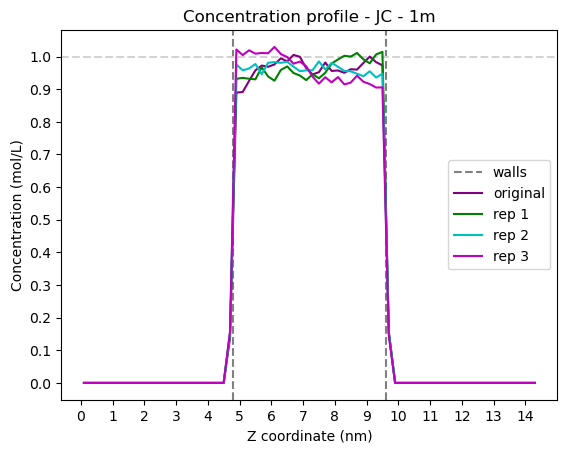

In [9]:
xo,yo=density_profile_conv(densprof_1m_o)
xr1,yr1=density_profile_conv(densprof_1m_r1)
xr2,yr2=density_profile_conv(densprof_1m_r2)
xr3,yr3=density_profile_conv(densprof_1m_r3)
plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(xo,yo, c='purple', label='original')
plt.plot(xr1,yr1, c='g', label='rep 1')
plt.plot(xr2,yr2, c='c', label='rep 2')
plt.plot(xr3,yr3, c='m', label='rep 3')
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Concentration profile - JC - 1m')
plt.legend()
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

### Density profile for 2m

### Density profile for 3m

## Density profiles using MDanalysis

In [10]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='atom', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins-1)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [11]:
# nbins,ncounts=density_profile(u,ions,2)
# nbins1,ncounts1=density_profile(u1,ions1,2)
# nbins2,ncounts2=density_profile(u2,ions2,2)
# nbins3,ncounts3=density_profile(u3,ions3,2)

### Density plots

In [12]:
nb=144.4/72
volbin=48*48*nb*angstrom**3
counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts1=(ncounts1/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

bins=nbins/10
bins1=nbins1/10
bins2=nbins2/10
bins3=nbins3/10

print(counts)

plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 9.6, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 1, color = 'lightgray', linestyle = 'dashed')
plt.plot(bins[1:],counts, c='orange', label='original')
plt.plot(bins1[1:],counts1, c='g', label='rep1')
plt.plot(bins2[1:],counts2, c='c', label='rep2')
plt.plot(bins3[1:],counts3, c='m', label='rep3')

plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 14.4, 1))
plt.title("Concentration profile of replicates - CHARMM27")
plt.legend()
plt.show()

NameError: name 'ncounts' is not defined